In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score, confusion_matrix, classification_report, roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [2]:
data = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

data = pd.get_dummies(data, columns=["Churn"], drop_first=True)

data = data[data["TotalCharges"] != " "]
data["TotalCharges"] = pd.to_numeric(data["TotalCharges"], errors="ignore")

train_set, test_set = train_test_split(data, test_size = 0.2, random_state=44)

data = train_set.drop(["customerID", "Churn_Yes"], axis=1)
data_labels = train_set["Churn_Yes"].copy()

data_num = data[["tenure", "MonthlyCharges", "TotalCharges"]]
data_cat = data.drop(columns=["tenure", "MonthlyCharges", "TotalCharges"])


num_attribs = list(data_num)
cat_attribs = list(data_cat)

full_pipeline = ColumnTransformer([
    ("num", Pipeline([
        ("poly", PolynomialFeatures(degree=5,
                                    include_bias=False,
                                    interaction_only=False)),
        ("scaler", StandardScaler()),
    ]), num_attribs),
    ("cat", OneHotEncoder(drop="first"), cat_attribs),
])

new_data = full_pipeline.fit_transform(data)

class DropTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, threshold):
        self.threshold = threshold
        print("It works!")
        
    def fit(self, X, y = None):
        
        return self
    
    def transform(self, X):

        data = pd.DataFrame(X)
        corr_matrix = data.corr(method="spearman")
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
        to_drop = [column for column in upper.columns if any(upper[column] > self.threshold)]
        transformed_data = np.array(data.drop(data.columns[to_drop], axis=1))
        
        return transformed_data

pipeline = Pipeline([("droper", DropTransformer(threshold = 0.95))])

data_prepared = pipeline.fit_transform(new_data)

X_train, X_val, y_train, y_val = train_test_split(data_prepared, data_labels, test_size = 0.25, random_state=44, stratify=data_labels)

It works!


### recall

In [3]:
params_grid = {
    "C": [0.1, 0.2, 0.25, 0.3, 0.5, 0.75, 1, 2],
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "degree": [1, 2, 3, 4, 5],
    "gamma": ["scale", "auto"],
    "probability": [True],
    "class_weight": [None, "balanced"]
}

gridsearch = GridSearchCV(estimator = SVC(random_state=44),
                          param_grid = params_grid,
                          scoring = "recall",
                          n_jobs = -1,
                          verbose = 1,
                          cv = 5
                         )

gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 640 candidates, totalling 3200 fits


GridSearchCV(cv=5, estimator=SVC(random_state=44), n_jobs=-1,
             param_grid={'C': [0.1, 0.2, 0.25, 0.3, 0.5, 0.75, 1, 2],
                         'class_weight': [None, 'balanced'],
                         'degree': [1, 2, 3, 4, 5], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                         'probability': [True]},
             scoring='recall', verbose=1)

In [5]:
gridsearch.best_estimator_

SVC(C=0.1, class_weight='balanced', degree=5, gamma='auto', kernel='poly',
    probability=True, random_state=44)

In [19]:
best_svc = SVC(C=0.1,
               class_weight='balanced',
               degree=5,
               gamma='auto',
               kernel='poly',
               probability=True,
               random_state=44
              )

best_svc.fit(X_train, y_train)

SVC(C=0.1, class_weight='balanced', degree=5, gamma='auto', kernel='poly',
    probability=True, random_state=44)

In [20]:
y_pred = best_svc.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.12      0.22      1035
           1       0.29      0.98      0.44       372

    accuracy                           0.35      1407
   macro avg       0.62      0.55      0.33      1407
weighted avg       0.77      0.35      0.28      1407



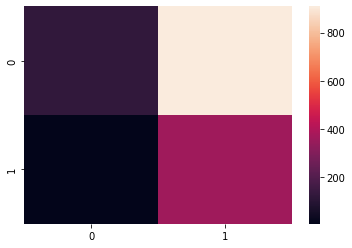

In [22]:
sns.heatmap(confusion_matrix(y_val, y_pred))

### f1

In [10]:
params_grid = {
    "C": [0.1, 0.2, 0.25, 0.3, 0.5, 0.75, 1, 2],
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "degree": [1, 2, 3, 4, 5],
    "gamma": ["scale", "auto"],
    "probability": [True],
    "class_weight": [None, "balanced"]
}

gridsearch = GridSearchCV(estimator = SVC(random_state=44),
                          param_grid = params_grid,
                          scoring = "f1",
                          n_jobs = -1,
                          verbose = 1,
                          cv = 5
                         )

gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 640 candidates, totalling 3200 fits


GridSearchCV(cv=5, estimator=SVC(random_state=44), n_jobs=-1,
             param_grid={'C': [0.1, 0.2, 0.25, 0.3, 0.5, 0.75, 1, 2],
                         'class_weight': [None, 'balanced'],
                         'degree': [1, 2, 3, 4, 5], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                         'probability': [True]},
             scoring='f1', verbose=1)

In [13]:
gridsearch.best_estimator_

SVC(C=0.2, class_weight='balanced', degree=4, kernel='poly', probability=True,
    random_state=44)

In [23]:
best_svc = SVC(C=0.2,
               class_weight='balanced',
               degree=4,
               gamma = "scale",
               kernel='poly',
               probability=True,
               random_state=44)

best_svc.fit(X_train, y_train)

SVC(C=0.2, class_weight='balanced', degree=4, kernel='poly', probability=True,
    random_state=44)

In [24]:
y_pred = best_svc.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.72      0.80      1035
           1       0.51      0.80      0.62       372

    accuracy                           0.74      1407
   macro avg       0.71      0.76      0.71      1407
weighted avg       0.80      0.74      0.75      1407



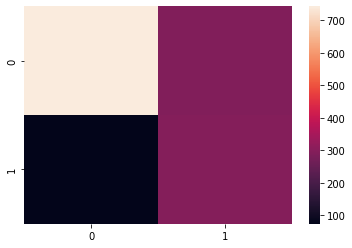

In [25]:
sns.heatmap(confusion_matrix(y_val, y_pred))

In [28]:
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

Best Threshold=0.284830, G-Mean=0.768


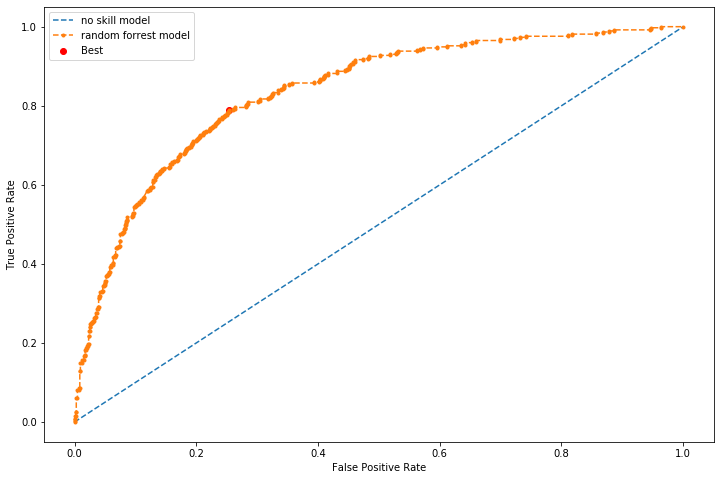

In [27]:
fpr, tpr, thresholds = roc_curve(y_val, best_svc.predict_proba(X_val)[:,1])

gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

plt.figure(figsize = (12, 8))
plt.plot([0,1], [0,1], linestyle='--', label='no skill model')
plt.plot(fpr, tpr, marker='.', linestyle='--', label='random forrest model')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='red', label='Best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [29]:
print(classification_report(y_val,
                            to_labels(best_svc.predict_proba(X_val)[:,1], thresholds[ix])))

              precision    recall  f1-score   support

           0       0.91      0.75      0.82      1035
           1       0.53      0.79      0.63       372

    accuracy                           0.76      1407
   macro avg       0.72      0.77      0.73      1407
weighted avg       0.81      0.76      0.77      1407

